# Set up

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
import nibabel.freesurfer.io as fsio
from nilearn import datasets, plotting
import random
import json
from adjustText import adjust_text
from matplotlib.patches import Ellipse

In [3]:
random.seed(42)
np.random.seed(42)

In [4]:
rename = pd.read_csv('/Users/baileyng/MIND_models/region_names/col_renames.csv')
rename_dict = dict(zip(rename['datafield_code'], rename['datafield_name']))

# PLS Analysis Function

In [5]:
def pct_var(pls: PLSRegression, X: np.ndarray, Y: np.ndarray):
    Xc = X - X.mean(axis=0)
    Yc = Y - Y.mean(axis=0)
    SSX = np.sum(Xc**2)
    SSY = np.sum(Yc**2)

    T = pls.x_scores_
    P = pls.x_loadings_
    Q = pls.y_loadings_

    pct_X = []
    pct_Y = []
    for k in range(1, pls.n_components+1):
        Tk = T[:, :k]
        Pk = P[:, :k]
        Qk = Q[:, :k]

        Xhat = Tk @ Pk.T
        Yhat = Tk @ Qk.T

        pct_X.append(100 * np.sum(Xhat**2) / SSX)
        pct_Y.append(100 * np.sum(Yhat**2) / SSY)

    return np.array(pct_X), np.array(pct_Y)

In [6]:
def varname_to_region(var):
    if var.startswith('lh_'):
        return 'lh', var.replace('lh_', '').replace('_thickness', '')
    elif var.startswith('rh_'):
        return 'rh', var.replace('rh_', '').replace('_thickness', '').replace('.', '')
    return None, None

# 2. Set FreeSurfer fsaverage path
fsaverage_path = '/Applications/freesurfer/subjects/fsaverage'

# 3. Load annotation files
lh_annot = fsio.read_annot(f'{fsaverage_path}/label/lh.aparc.annot')
rh_annot = fsio.read_annot(f'{fsaverage_path}/label/rh.aparc.annot')
lh_labels, lh_cmap, lh_names = lh_annot
rh_labels, rh_cmap, rh_names = rh_annot
lh_names = [name.decode('utf-8') for name in lh_names]
rh_names = [name.decode('utf-8') for name in rh_names]

In [7]:
def pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10):
    preprocessor = ColumnTransformer(transformers=[
        # scale continuous features
        ('num', StandardScaler(), continuous_vars),
        # one-hot encode the assessment centre (drop one level to avoid collinearity)
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_vars),
    ])

    # Cross-validation set-up
    outer_cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    outer_mae, outer_rmse, outer_r2 = [], [], []
    best_ncomps = []
    coefs_list = []
    # vip_list = []

    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), start=1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Inner CV
        pipe = make_pipeline(
            preprocessor,
            PLSRegression()
        )

        param_grid = {
            'plsregression__n_components': list(range(1, 11))
        }

        inner_cv = KFold(n_splits=10, shuffle=True, random_state=42)
        grid = GridSearchCV(
            pipe, 
            param_grid, 
            cv=inner_cv, 
            scoring='neg_mean_squared_error',  # or 'r2'
            n_jobs=-1
        )
        
        grid.fit(X_train, y_train)
        best_n = grid.best_params_['plsregression__n_components']
        best_ncomps.append(best_n)
        
        y_pred = grid.predict(X_test)

        # --- metrics ---
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        outer_mae.append(mae)
        outer_rmse.append(rmse)
        outer_r2.append(r2)

        # --- extract loadings and compute VIP ---
        pls = grid.best_estimator_.named_steps['plsregression']
        coefs_list.append(pls.coef_.ravel())
        
        T = pls.x_scores_
        W = pls.x_weights_
        Q = pls.y_loadings_
        p, h = W.shape

        # # S = np.sum((T ** 2) * (Q.T ** 2), axis=0)
        # S = np.sum((T ** 2) * (Q ** 2), axis=0)
        # total_S = np.sum(S)
        # vip = np.zeros(p)
        # for j in range(p):
        #     # weight_sq = [(W[j, k] ** 2) * S[k] for k in range(h)]
        #     # vip[j] = np.sqrt(p * np.sum(weight_sq) / total_S)
        #     vip[j] = np.sqrt(p * np.sum((W[j, :]**2) * S) / total_S)
        # vip_list.append(vip)

        print(f'Fold {fold:02d} • n_comp={best_n:02d} • '
            f'MAE={mae:.3f} • RMSE={rmse:.3f} • R²={r2:.3f}')
        

    # Aggregate results
    print('\n=== 10-fold CV summary ===')
    print(f'n_components (mean ± std): '
        f'{np.mean(best_ncomps):.1f} ± {np.std(best_ncomps):.1f}')
    print(f'MAE :  {np.mean(outer_mae):.3f} ± {np.std(outer_mae):.3f}')
    print(f'RMSE:  {np.mean(outer_rmse):.3f} ± {np.std(outer_rmse):.3f}')
    print(f'R²  :  {np.mean(outer_r2):.3f} ± {np.std(outer_r2):.3f}')

    # # Get feature names after preprocessing
    # # First, fit the preprocessor to get the transformed feature names
    # preprocessor_fitted = preprocessor.fit(X)

    # # Get feature names for each transformer
    # num_features = continuous_vars
    # cat_features = list(preprocessor_fitted.named_transformers_['cat'].get_feature_names_out(categorical_vars))

    # # Combine all feature names in the correct order
    # all_feature_names = num_features + cat_features


    # # Final refit on all data
    # final_pipe = make_pipeline(
    #     preprocessor,
    #     PLSRegression(
    #         n_components=int(np.round(np.mean(best_ncomps))),
    #     )
    # ).fit(X, y)

    # pls = final_pipe.named_steps['plsregression']
    # ct  = final_pipe.named_steps['columntransformer']




    # # 3) re-transform your original X to the exact matrix PLS saw
    # X_proc = ct.transform(X)            # this is a NumPy array, shape (n_samples, n_features')

    # # 4) compute the cumulative % variance explained
    # X_pctvar, Y_pctvar = pct_var(pls, X_proc, y)

    # print("Percentage of variance explained:")
    # print("Component\tX (Predictors)\tY (Response)")
    # print("-" * 40)
    # for i in range(len(X_pctvar)):
    #     print(f"PLS{i+1}\t\t{X_pctvar[i]:.2f}%\t\t{Y_pctvar[i]:.2f}%")

    # print(f"\nTotal variance explained:")
    # print(f"X: {X_pctvar[-1]:.2f}%")
    # print(f"Y: {Y_pctvar[-1]:.2f}%")

    # # Plot the results
    # plt.figure(figsize=(10, 6))
    # components = np.arange(1, len(X_pctvar) + 1)
    # plt.plot(components, X_pctvar, 'b-o', label='X (Predictors)', linewidth=2)
    # plt.plot(components, Y_pctvar, 'r-o', label='Y (Fluid Intelligence)', linewidth=2)
    # plt.xlabel('PLS Component')
    # plt.ylabel('Cumulative Variance Explained (%)')
    # plt.title('Percentage of Variance Explained by PLS Components')
    # plt.legend()
    # plt.grid(True, alpha=0.3)
    # plt.xticks(components)
    # plt.show()


    # T = pls.x_scores_

    # # Scatter plot of Fluid Intelligence Score vs PLS1 scores
    # plt.figure(figsize=(8, 6))
    # plt.scatter(T[:,0], y, alpha=0.6, s=12, color='blue')
    # plt.xlabel("PLS1 Scores")
    # plt.ylabel("Fluid Intelligence Score")
    # plt.title("Fluid Intelligence Score vs PLS1 Scores")
    # plt.show()

    # # Scatter plot of Fluid Intelligence Score vs PLS2 scores
    # plt.figure(figsize=(8, 6))
    # plt.scatter(T[:,1], y, alpha=0.6, s=12, color='red')
    # plt.xlabel("PLS2 Scores")
    # plt.ylabel("Fluid Intelligence Score")
    # plt.title("Fluid Intelligence Score vs PLS2 Scores")
    # plt.show()

    # W = pls.x_weights_
    # plt.figure(figsize=(12, 6))
    # plt.bar(all_feature_names, W[:,0])
    # plt.xticks(rotation=90)
    # plt.title("PLS1 Weights")
    # plt.tight_layout()
    # plt.show()

    # plt.figure(figsize=(12, 6))
    # plt.bar(all_feature_names, W[:,1])
    # plt.xticks(rotation=90)
    # plt.title("PLS2 Weights")
    # plt.tight_layout()
    # plt.show()

    # plt.figure(figsize=(12, 6))
    # plt.bar(all_feature_names, W[:,2])
    # plt.xticks(rotation=90)
    # plt.title("PLS3 Weights")
    # plt.tight_layout()
    # plt.show()


    # # # Calculate Z-scores for the weights
    # # W1_mean = np.mean(W[:, 0])
    # # W1_std = np.std(W[:, 0])
    # # W2_mean = np.mean(W[:, 1])
    # # W2_std = np.std(W[:, 1])

    # # plt.figure(figsize=(8, 10))
    # # plt.axhline(0, color='grey', lw=1)
    # # plt.axvline(0, color='grey', lw=1)

    # # # Draw arrows for each variable
    # # for i, var in enumerate(all_feature_names):
    # #     plt.arrow(0, 0, W[i, 0], W[i, 1], 
    # #             color='b', alpha=0.6, head_width=0.01, head_length=0.01, length_includes_head=True)

    # # # Label all variables, closer to the arrow tip
    # # texts = []
    # # for i, var in enumerate(all_feature_names):
    # #     texts.append(
    # #         plt.text(W[i, 0]*1.02, W[i, 1]*1.02, var, color='r', ha='center', va='center', 
    # #                 fontsize=8, clip_on=True)
    # #     )

    # # ellipse = Ellipse((0, 0), 
    # #                 width=6*W1_std, height=6*W2_std,  # 6 = 2*3 std devs (±3)
    # #                 fill=False, color='g', linestyle='--', linewidth=2, 
    # #                 label='Z-score = ±3 (elliptical)')
    # # plt.gca().add_patch(ellipse)

    # # adjust_text(texts, arrowprops=dict(arrowstyle='-', color='grey', lw=0.5), 
    # #             expand_points=(1.2, 1.2), expand_text=(1.2, 1.2), force_text=0.5, force_points=0.5)

    # # plt.xlabel("PLS1 Weight")
    # # plt.ylabel("PLS2 Weight")
    # # plt.title("PLS Weight Plot")
    # # plt.grid(True)
    # # plt.axis('equal')
    # # plt.tight_layout()
    # # plt.legend()
    # # plt.show()

    # # 1. Variable names and coefficients
    # vars_to_plot = np.array(all_feature_names)
    # means = pls.x_weights_[:,0]

    # # 4. Prepare vertex data arrays
    # lh_vertex_data = np.full_like(lh_labels, np.nan, dtype=float)
    # rh_vertex_data = np.full_like(rh_labels, np.nan, dtype=float)

    # for var, coef in zip(vars_to_plot, means):
    #     hemi, region = varname_to_region(var)
    #     if hemi == 'lh':
    #         idxs = [i for i, n in enumerate(lh_names) if region.lower() in n.lower()]
    #         for idx in idxs:
    #             lh_vertex_data[lh_labels == idx] = coef
    #     elif hemi == 'rh':
    #         idxs = [i for i, n in enumerate(rh_names) if region.lower() in n.lower()]
    #         for idx in idxs:
    #             rh_vertex_data[rh_labels == idx] = coef

    # # 5. Load inflated_pre surfaces
    # lh_inflated_pre_path = f'{fsaverage_path}/surf/lh.inflated_pre'
    # rh_inflated_pre_path = f'{fsaverage_path}/surf/rh.inflated_pre'
    # lh_coords, lh_faces = fsio.read_geometry(lh_inflated_pre_path)
    # rh_coords, rh_faces = fsio.read_geometry(rh_inflated_pre_path)
    # lh_mesh = (lh_coords, lh_faces)
    # rh_mesh = (rh_coords, rh_faces)

    # # 6. Load fsaverage sulcal maps for background
    # fsavg = datasets.fetch_surf_fsaverage('fsaverage')
    # sulc_left = fsavg.sulc_left
    # sulc_right = fsavg.sulc_right

    # # 7. Plotting function
    # global_vmax = np.nanmax(np.abs(np.concatenate([lh_vertex_data, rh_vertex_data])))

    # def plot_three_views_custom(surf_mesh, vertex_data, bg_map, hemi, title):
    #     views = ['lateral', 'medial', 'dorsal']
    #     fig, axes = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(40, 20))
    #     cmap = 'seismic'
    #     for i, view in enumerate(views):
    #         plotting.plot_surf_stat_map(
    #             surf_mesh, vertex_data, hemi=hemi, bg_map=bg_map,
    #             cmap=cmap, colorbar=False, vmax=global_vmax, vmin=-global_vmax, symmetric_cbar=True,
    #             view=view, axes=axes[i], title='', figure=fig, alpha=0.9
    #         )
    #         axes[i].set_title(view.capitalize(), fontsize=30)
    #         axes[i].axis('off')
    #     # Colorbar
    #     cbar_ax = fig.add_axes([0.33, 0.09, 0.34, 0.03])
    #     norm = plt.Normalize(vmin=-global_vmax, vmax=global_vmax)
    #     cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, orientation='horizontal')
    #     cb.set_label('PLS1 Weights', fontsize=16)
    #     cb.ax.tick_params(labelsize=18)
    #     plt.suptitle(title, fontsize=38, y=0.96)
    #     plt.tight_layout(rect=[0, 0.15, 1, 0.92])
    #     plt.show()

    # # 8. Plot with inflated_pre
    # plot_three_views_custom(lh_mesh, lh_vertex_data, sulc_left, 'left', '(Demographic + MIND)')
    # plot_three_views_custom(rh_mesh, rh_vertex_data, sulc_right, 'right', '(Demographic + MIND)')

    # # 1. Variable names and coefficients
    # vars_to_plot = np.array(all_feature_names)
    # means = pls.x_weights_[:,1]

    # # 4. Prepare vertex data arrays
    # lh_vertex_data = np.full_like(lh_labels, np.nan, dtype=float)
    # rh_vertex_data = np.full_like(rh_labels, np.nan, dtype=float)

    # for var, coef in zip(vars_to_plot, means):
    #     hemi, region = varname_to_region(var)
    #     if hemi == 'lh':
    #         idxs = [i for i, n in enumerate(lh_names) if region.lower() in n.lower()]
    #         for idx in idxs:
    #             lh_vertex_data[lh_labels == idx] = coef
    #     elif hemi == 'rh':
    #         idxs = [i for i, n in enumerate(rh_names) if region.lower() in n.lower()]
    #         for idx in idxs:
    #             rh_vertex_data[rh_labels == idx] = coef

    # # 5. Load inflated_pre surfaces
    # lh_inflated_pre_path = f'{fsaverage_path}/surf/lh.inflated_pre'
    # rh_inflated_pre_path = f'{fsaverage_path}/surf/rh.inflated_pre'
    # lh_coords, lh_faces = fsio.read_geometry(lh_inflated_pre_path)
    # rh_coords, rh_faces = fsio.read_geometry(rh_inflated_pre_path)
    # lh_mesh = (lh_coords, lh_faces)
    # rh_mesh = (rh_coords, rh_faces)

    # # 6. Load fsaverage sulcal maps for background
    # fsavg = datasets.fetch_surf_fsaverage('fsaverage')
    # sulc_left = fsavg.sulc_left
    # sulc_right = fsavg.sulc_right

    # # 7. Plotting function
    # global_vmax = np.nanmax(np.abs(np.concatenate([lh_vertex_data, rh_vertex_data])))

    # def plot_three_views_custom(surf_mesh, vertex_data, bg_map, hemi, title):
    #     views = ['lateral', 'medial', 'dorsal']
    #     fig, axes = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(40, 20))
    #     cmap = 'seismic'
    #     for i, view in enumerate(views):
    #         plotting.plot_surf_stat_map(
    #             surf_mesh, vertex_data, hemi=hemi, bg_map=bg_map,
    #             cmap=cmap, colorbar=False, vmax=global_vmax, vmin=-global_vmax, symmetric_cbar=True,
    #             view=view, axes=axes[i], title='', figure=fig, alpha=0.9
    #         )
    #         axes[i].set_title(view.capitalize(), fontsize=30)
    #         axes[i].axis('off')
    #     # Colorbar
    #     cbar_ax = fig.add_axes([0.33, 0.09, 0.34, 0.03])
    #     norm = plt.Normalize(vmin=-global_vmax, vmax=global_vmax)
    #     cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, orientation='horizontal')
    #     cb.set_label('PLS2 Weights', fontsize=16)
    #     cb.ax.tick_params(labelsize=18)
    #     plt.suptitle(title, fontsize=38, y=0.96)
    #     plt.tight_layout(rect=[0, 0.15, 1, 0.92])
    #     plt.show()

    # # 8. Plot with inflated_pre
    # plot_three_views_custom(lh_mesh, lh_vertex_data, sulc_left, 'left', '(Demographic + MIND)')
    # plot_three_views_custom(rh_mesh, rh_vertex_data, sulc_right, 'right', '(Demographic + MIND)')

    # # 1. Variable names and coefficients
    # vars_to_plot = np.array(all_feature_names)
    # means = pls.x_weights_[:,2]

    # # 4. Prepare vertex data arrays
    # lh_vertex_data = np.full_like(lh_labels, np.nan, dtype=float)
    # rh_vertex_data = np.full_like(rh_labels, np.nan, dtype=float)

    # for var, coef in zip(vars_to_plot, means):
    #     hemi, region = varname_to_region(var)
    #     if hemi == 'lh':
    #         idxs = [i for i, n in enumerate(lh_names) if region.lower() in n.lower()]
    #         for idx in idxs:
    #             lh_vertex_data[lh_labels == idx] = coef
    #     elif hemi == 'rh':
    #         idxs = [i for i, n in enumerate(rh_names) if region.lower() in n.lower()]
    #         for idx in idxs:
    #             rh_vertex_data[rh_labels == idx] = coef

    # # 5. Load inflated_pre surfaces
    # lh_inflated_pre_path = f'{fsaverage_path}/surf/lh.inflated_pre'
    # rh_inflated_pre_path = f'{fsaverage_path}/surf/rh.inflated_pre'
    # lh_coords, lh_faces = fsio.read_geometry(lh_inflated_pre_path)
    # rh_coords, rh_faces = fsio.read_geometry(rh_inflated_pre_path)
    # lh_mesh = (lh_coords, lh_faces)
    # rh_mesh = (rh_coords, rh_faces)

    # # 6. Load fsaverage sulcal maps for background
    # fsavg = datasets.fetch_surf_fsaverage('fsaverage')
    # sulc_left = fsavg.sulc_left
    # sulc_right = fsavg.sulc_right

    # # 7. Plotting function
    # global_vmax = np.nanmax(np.abs(np.concatenate([lh_vertex_data, rh_vertex_data])))

    # def plot_three_views_custom(surf_mesh, vertex_data, bg_map, hemi, title):
    #     views = ['lateral', 'medial', 'dorsal']
    #     fig, axes = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(40, 20))
    #     cmap = 'seismic'
    #     for i, view in enumerate(views):
    #         plotting.plot_surf_stat_map(
    #             surf_mesh, vertex_data, hemi=hemi, bg_map=bg_map,
    #             cmap=cmap, colorbar=False, vmax=global_vmax, vmin=-global_vmax, symmetric_cbar=True,
    #             view=view, axes=axes[i], title='', figure=fig, alpha=0.9
    #         )
    #         axes[i].set_title(view.capitalize(), fontsize=30)
    #         axes[i].axis('off')
    #     # Colorbar
    #     cbar_ax = fig.add_axes([0.33, 0.09, 0.34, 0.03])
    #     norm = plt.Normalize(vmin=-global_vmax, vmax=global_vmax)
    #     cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, orientation='horizontal')
    #     cb.set_label('PLS3 Weights', fontsize=16)
    #     cb.ax.tick_params(labelsize=18)
    #     plt.suptitle(title, fontsize=38, y=0.96)
    #     plt.tight_layout(rect=[0, 0.15, 1, 0.92])
    #     plt.show()

    # # 8. Plot with inflated_pre
    # plot_three_views_custom(lh_mesh, lh_vertex_data, sulc_left, 'left', '(Demographic + MIND)')
    # plot_three_views_custom(rh_mesh, rh_vertex_data, sulc_right, 'right', '(Demographic + MIND)')




# GF

In [7]:
# Load the dataset
df = pd.read_csv('/Users/baileyng/MIND_data/ukb_master_GF_no_outliers.csv', index_col=0)

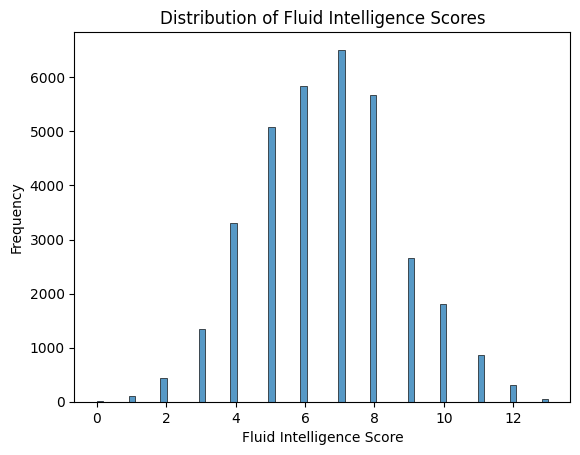

In [8]:
# Histogram of Fluid Intelligence Scores
sns.histplot(df['20016-2.0'])
plt.title('Distribution of Fluid Intelligence Scores')
plt.xlabel('Fluid Intelligence Score')
plt.ylabel('Frequency')
plt.show()

In [9]:
print(len(df))
print(df.shape)

33977
(33977, 2628)


## GF vs. MIND (avg)

In [10]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_avg_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['20016-2.0']

print(X.shape)
print(y.shape)

(33977, 71)
(33977,)


In [11]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [12]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

Fold 01 • n_comp=04 • MAE=1.621 • RMSE=2.020 • R²=0.029
Fold 02 • n_comp=04 • MAE=1.636 • RMSE=2.034 • R²=0.031
Fold 03 • n_comp=03 • MAE=1.643 • RMSE=2.043 • R²=0.039
Fold 04 • n_comp=04 • MAE=1.653 • RMSE=2.059 • R²=0.032
Fold 05 • n_comp=03 • MAE=1.605 • RMSE=2.004 • R²=0.030
Fold 06 • n_comp=03 • MAE=1.585 • RMSE=1.976 • R²=0.043
Fold 07 • n_comp=03 • MAE=1.617 • RMSE=2.018 • R²=0.032
Fold 08 • n_comp=03 • MAE=1.657 • RMSE=2.052 • R²=0.022
Fold 09 • n_comp=03 • MAE=1.607 • RMSE=2.002 • R²=0.036
Fold 10 • n_comp=04 • MAE=1.629 • RMSE=2.034 • R²=0.035

=== 10-fold CV summary ===
n_components (mean ± std): 3.4 ± 0.5
MAE :  1.625 ± 0.022
RMSE:  2.024 ± 0.024
R²  :  0.033 ± 0.005


## GF vs. MIND

In [12]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['20016-2.0']

print(X.shape)
print(y.shape)

(33977, 2281)
(33977,)


In [ ]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

Columns renamed successfully.


In [14]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

Fold 01 • n_comp=06 • MAE=1.605 • RMSE=2.005 • R²=0.044
Fold 02 • n_comp=06 • MAE=1.624 • RMSE=2.024 • R²=0.041
Fold 03 • n_comp=06 • MAE=1.633 • RMSE=2.038 • R²=0.044
Fold 04 • n_comp=06 • MAE=1.651 • RMSE=2.058 • R²=0.033
Fold 05 • n_comp=06 • MAE=1.601 • RMSE=1.997 • R²=0.037
Fold 06 • n_comp=06 • MAE=1.565 • RMSE=1.957 • R²=0.061
Fold 07 • n_comp=06 • MAE=1.606 • RMSE=2.008 • R²=0.041
Fold 08 • n_comp=06 • MAE=1.646 • RMSE=2.037 • R²=0.037
Fold 09 • n_comp=06 • MAE=1.603 • RMSE=1.997 • R²=0.040
Fold 10 • n_comp=06 • MAE=1.625 • RMSE=2.035 • R²=0.034

=== 10-fold CV summary ===
n_components (mean ± std): 6.0 ± 0.0
MAE :  1.616 ± 0.024
RMSE:  2.016 ± 0.027
R²  :  0.041 ± 0.008


## GF vs. CT

In [13]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/CT_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['20016-2.0']

print(X.shape)
print(y.shape)

(33977, 65)
(33977,)


In [14]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [15]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

Fold 01 • n_comp=06 • MAE=1.632 • RMSE=2.032 • R²=0.018
Fold 02 • n_comp=05 • MAE=1.644 • RMSE=2.042 • R²=0.024
Fold 03 • n_comp=09 • MAE=1.651 • RMSE=2.057 • R²=0.026
Fold 04 • n_comp=05 • MAE=1.662 • RMSE=2.070 • R²=0.021
Fold 05 • n_comp=05 • MAE=1.604 • RMSE=2.002 • R²=0.032
Fold 06 • n_comp=05 • MAE=1.589 • RMSE=1.985 • R²=0.035
Fold 07 • n_comp=06 • MAE=1.631 • RMSE=2.035 • R²=0.015
Fold 08 • n_comp=08 • MAE=1.652 • RMSE=2.046 • R²=0.028
Fold 09 • n_comp=09 • MAE=1.623 • RMSE=2.016 • R²=0.022
Fold 10 • n_comp=06 • MAE=1.637 • RMSE=2.043 • R²=0.026

=== 10-fold CV summary ===
n_components (mean ± std): 6.4 ± 1.6
MAE :  1.632 ± 0.021
RMSE:  2.033 ± 0.024
R²  :  0.025 ± 0.006


## GF vs. FC

In [16]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/FC_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0', '25741-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['20016-2.0']

print(X.shape)
print(y.shape)

(33977, 214)
(33977,)


In [17]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [18]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fold 01 • n_comp=05 • MAE=1.581 • RMSE=1.985 • R²=0.063
Fold 02 • n_comp=05 • MAE=1.599 • RMSE=1.990 • R²=0.073
Fold 03 • n_comp=05 • MAE=1.615 • RMSE=2.020 • R²=0.060
Fold 04 • n_comp=05 • MAE=1.615 • RMSE=2.018 • R²=0.070
Fold 05 • n_comp=05 • MAE=1.573 • RMSE=1.964 • R²=0.068
Fold 06 • n_comp=05 • MAE=1.545 • RMSE=1.929 • R²=0.088
Fold 07 • n_comp=05 • MAE=1.598 • RMSE=1.995 • R²=0.053
Fold 08 • n_comp=05 • MAE=1.604 • RMSE=2.000 • R²=0.071
Fold 09 • n_comp=05 • MAE=1.572 • RMSE=1.965 • R²=0.070
Fold 10 • n_comp=05 • MAE=1.590 • RMSE=1.987 • R²=0.079

=== 10-fold CV summary ===
n_components (mean ± std): 5.0 ± 0.0
MAE :  1.589 ± 0.021
RMSE:  1.985 ± 0.026
R²  :  0.070 ± 0.009


# PAL

In [7]:
# Load the dataset
df = pd.read_csv('/Users/baileyng/MIND_data/ukb_master_PAL_no_outliers.csv', index_col=0)

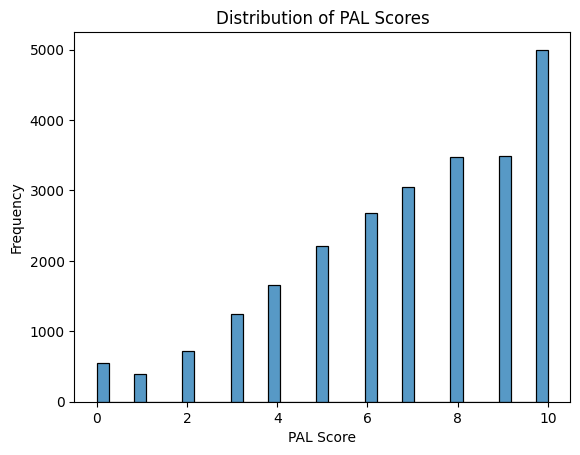

In [8]:
# Histogram of PAL Scores
sns.histplot(df['20197-2.0'])
plt.title('Distribution of PAL Scores')
plt.xlabel('PAL Score')
plt.ylabel('Frequency')
plt.show()

In [9]:
print(len(df))
print(df.shape)

24492
(24492, 2628)


### PAL vs. MIND (avg)

In [10]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_avg_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['20197-2.0']

print(X.shape)
print(y.shape)

(24492, 71)
(24492,)


In [11]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [12]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

Fold 01 • n_comp=05 • MAE=2.076 • RMSE=2.539 • R²=0.064
Fold 02 • n_comp=05 • MAE=2.104 • RMSE=2.551 • R²=0.046
Fold 03 • n_comp=05 • MAE=2.098 • RMSE=2.584 • R²=0.062
Fold 04 • n_comp=04 • MAE=2.071 • RMSE=2.533 • R²=0.059
Fold 05 • n_comp=05 • MAE=2.040 • RMSE=2.476 • R²=0.053
Fold 06 • n_comp=04 • MAE=2.105 • RMSE=2.559 • R²=0.081
Fold 07 • n_comp=05 • MAE=2.089 • RMSE=2.538 • R²=0.062
Fold 08 • n_comp=05 • MAE=2.068 • RMSE=2.536 • R²=0.065
Fold 09 • n_comp=05 • MAE=2.082 • RMSE=2.554 • R²=0.066
Fold 10 • n_comp=05 • MAE=2.070 • RMSE=2.542 • R²=0.047

=== 10-fold CV summary ===
n_components (mean ± std): 4.8 ± 0.4
MAE :  2.080 ± 0.019
RMSE:  2.541 ± 0.026
R²  :  0.061 ± 0.009


### PAL vs. MIND

In [13]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['20197-2.0']

print(X.shape)
print(y.shape)

(24492, 2281)
(24492,)


In [14]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [15]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

Fold 01 • n_comp=07 • MAE=2.088 • RMSE=2.558 • R²=0.050
Fold 02 • n_comp=07 • MAE=2.105 • RMSE=2.551 • R²=0.046
Fold 03 • n_comp=07 • MAE=2.105 • RMSE=2.589 • R²=0.058
Fold 04 • n_comp=09 • MAE=2.091 • RMSE=2.564 • R²=0.036
Fold 05 • n_comp=07 • MAE=2.061 • RMSE=2.501 • R²=0.035
Fold 06 • n_comp=06 • MAE=2.129 • RMSE=2.598 • R²=0.052
Fold 07 • n_comp=08 • MAE=2.113 • RMSE=2.576 • R²=0.034
Fold 08 • n_comp=06 • MAE=2.085 • RMSE=2.557 • R²=0.049
Fold 09 • n_comp=09 • MAE=2.092 • RMSE=2.571 • R²=0.054
Fold 10 • n_comp=06 • MAE=2.088 • RMSE=2.559 • R²=0.035

=== 10-fold CV summary ===
n_components (mean ± std): 7.2 ± 1.1
MAE :  2.096 ± 0.018
RMSE:  2.562 ± 0.025
R²  :  0.045 ± 0.009


### PAL vs. CT

In [16]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/CT_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['20197-2.0']

print(X.shape)
print(y.shape)

(24492, 65)
(24492,)


In [17]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [18]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

Fold 01 • n_comp=05 • MAE=2.081 • RMSE=2.537 • R²=0.066
Fold 02 • n_comp=05 • MAE=2.106 • RMSE=2.556 • R²=0.043
Fold 03 • n_comp=05 • MAE=2.096 • RMSE=2.581 • R²=0.064
Fold 04 • n_comp=05 • MAE=2.065 • RMSE=2.532 • R²=0.060
Fold 05 • n_comp=05 • MAE=2.041 • RMSE=2.475 • R²=0.055
Fold 06 • n_comp=06 • MAE=2.107 • RMSE=2.564 • R²=0.077
Fold 07 • n_comp=05 • MAE=2.087 • RMSE=2.537 • R²=0.063
Fold 08 • n_comp=05 • MAE=2.073 • RMSE=2.540 • R²=0.061
Fold 09 • n_comp=05 • MAE=2.084 • RMSE=2.554 • R²=0.066
Fold 10 • n_comp=05 • MAE=2.076 • RMSE=2.542 • R²=0.048

=== 10-fold CV summary ===
n_components (mean ± std): 5.1 ± 0.3
MAE :  2.082 ± 0.019
RMSE:  2.542 ± 0.027
R²  :  0.060 ± 0.009


### PAL vs. FC

In [19]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/FC_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0', '25741-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['20197-2.0']

print(X.shape)
print(y.shape)

(24492, 214)
(24492,)


In [20]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [21]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

Fold 01 • n_comp=09 • MAE=2.035 • RMSE=2.503 • R²=0.091
Fold 02 • n_comp=10 • MAE=2.039 • RMSE=2.497 • R²=0.087
Fold 03 • n_comp=09 • MAE=2.055 • RMSE=2.543 • R²=0.091
Fold 04 • n_comp=09 • MAE=2.035 • RMSE=2.496 • R²=0.087
Fold 05 • n_comp=10 • MAE=1.994 • RMSE=2.423 • R²=0.093
Fold 06 • n_comp=09 • MAE=2.053 • RMSE=2.523 • R²=0.106
Fold 07 • n_comp=10 • MAE=2.031 • RMSE=2.487 • R²=0.099
Fold 08 • n_comp=09 • MAE=2.032 • RMSE=2.500 • R²=0.091
Fold 09 • n_comp=09 • MAE=2.037 • RMSE=2.515 • R²=0.094
Fold 10 • n_comp=10 • MAE=2.016 • RMSE=2.484 • R²=0.091

=== 10-fold CV summary ===
n_components (mean ± std): 9.4 ± 0.5
MAE :  2.033 ± 0.017
RMSE:  2.497 ± 0.030
R²  :  0.093 ± 0.006


# DSST

In [22]:
# Load the dataset
df = pd.read_csv('/Users/baileyng/MIND_data/ukb_master_DSST_no_outliers.csv', index_col=0)

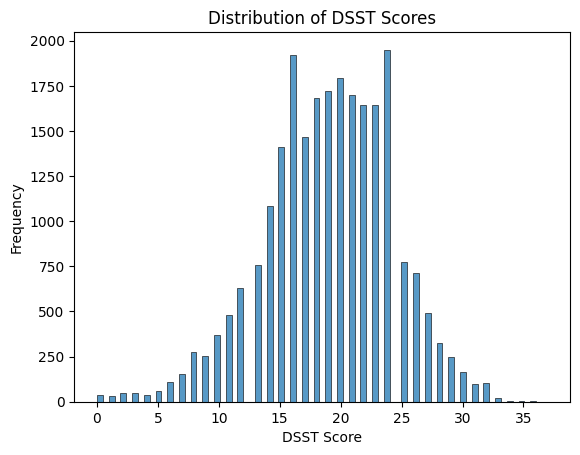

In [23]:
# Histogram of DSST Scores
sns.histplot(df['23324-2.0'])
plt.title('Distribution of DSST Scores')
plt.xlabel('DSST Score')
plt.ylabel('Frequency')
plt.show()

In [24]:
print(len(df))
print(df.shape)

24275
(24275, 2628)


### DSST vs. MIND (avg)

In [25]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_avg_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['23324-2.0']

print(X.shape)
print(y.shape)

(24275, 71)
(24275,)


In [26]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [27]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

Fold 01 • n_comp=05 • MAE=3.703 • RMSE=4.712 • R²=0.193
Fold 02 • n_comp=06 • MAE=3.804 • RMSE=4.845 • R²=0.207
Fold 03 • n_comp=05 • MAE=3.725 • RMSE=4.712 • R²=0.200
Fold 04 • n_comp=06 • MAE=3.665 • RMSE=4.619 • R²=0.161
Fold 05 • n_comp=06 • MAE=3.782 • RMSE=4.816 • R²=0.181
Fold 06 • n_comp=06 • MAE=3.701 • RMSE=4.738 • R²=0.195
Fold 07 • n_comp=06 • MAE=3.738 • RMSE=4.754 • R²=0.188
Fold 08 • n_comp=06 • MAE=3.713 • RMSE=4.738 • R²=0.184
Fold 09 • n_comp=06 • MAE=3.640 • RMSE=4.636 • R²=0.189
Fold 10 • n_comp=06 • MAE=3.650 • RMSE=4.597 • R²=0.203

=== 10-fold CV summary ===
n_components (mean ± std): 5.8 ± 0.4
MAE :  3.712 ± 0.050
RMSE:  4.717 ± 0.077
R²  :  0.190 ± 0.013


### DSST vs. MIND

In [28]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['23324-2.0']

print(X.shape)
print(y.shape)

(24275, 2281)
(24275,)


In [29]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [30]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

Fold 01 • n_comp=10 • MAE=3.764 • RMSE=4.769 • R²=0.173
Fold 02 • n_comp=10 • MAE=3.865 • RMSE=4.909 • R²=0.186
Fold 03 • n_comp=10 • MAE=3.760 • RMSE=4.766 • R²=0.181
Fold 04 • n_comp=10 • MAE=3.686 • RMSE=4.673 • R²=0.141
Fold 05 • n_comp=10 • MAE=3.821 • RMSE=4.863 • R²=0.165
Fold 06 • n_comp=10 • MAE=3.772 • RMSE=4.812 • R²=0.170
Fold 07 • n_comp=10 • MAE=3.816 • RMSE=4.831 • R²=0.162
Fold 08 • n_comp=10 • MAE=3.761 • RMSE=4.808 • R²=0.159
Fold 09 • n_comp=10 • MAE=3.675 • RMSE=4.670 • R²=0.178
Fold 10 • n_comp=10 • MAE=3.686 • RMSE=4.649 • R²=0.185

=== 10-fold CV summary ===
n_components (mean ± std): 10.0 ± 0.0
MAE :  3.761 ± 0.060
RMSE:  4.775 ± 0.083
R²  :  0.170 ± 0.013


### DSST vs. CT

In [31]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/CT_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['23324-2.0']

print(X.shape)
print(y.shape)

(24275, 65)
(24275,)


In [32]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [33]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

Fold 01 • n_comp=06 • MAE=3.709 • RMSE=4.711 • R²=0.193
Fold 02 • n_comp=06 • MAE=3.811 • RMSE=4.845 • R²=0.207
Fold 03 • n_comp=06 • MAE=3.715 • RMSE=4.713 • R²=0.199
Fold 04 • n_comp=06 • MAE=3.659 • RMSE=4.612 • R²=0.163
Fold 05 • n_comp=06 • MAE=3.789 • RMSE=4.831 • R²=0.176
Fold 06 • n_comp=06 • MAE=3.700 • RMSE=4.728 • R²=0.198
Fold 07 • n_comp=06 • MAE=3.743 • RMSE=4.774 • R²=0.181
Fold 08 • n_comp=06 • MAE=3.722 • RMSE=4.751 • R²=0.179
Fold 09 • n_comp=06 • MAE=3.643 • RMSE=4.639 • R²=0.188
Fold 10 • n_comp=06 • MAE=3.652 • RMSE=4.610 • R²=0.198

=== 10-fold CV summary ===
n_components (mean ± std): 6.0 ± 0.0
MAE :  3.714 ± 0.053
RMSE:  4.721 ± 0.079
R²  :  0.188 ± 0.013


### DSST vs. FC

In [34]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/FC_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0', '25741-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['23324-2.0']

print(X.shape)
print(y.shape)

(24275, 214)
(24275,)


In [35]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [36]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

Fold 01 • n_comp=09 • MAE=3.647 • RMSE=4.658 • R²=0.211
Fold 02 • n_comp=09 • MAE=3.773 • RMSE=4.814 • R²=0.217
Fold 03 • n_comp=09 • MAE=3.699 • RMSE=4.674 • R²=0.213
Fold 04 • n_comp=09 • MAE=3.648 • RMSE=4.611 • R²=0.164
Fold 05 • n_comp=09 • MAE=3.779 • RMSE=4.796 • R²=0.188
Fold 06 • n_comp=09 • MAE=3.669 • RMSE=4.691 • R²=0.211
Fold 07 • n_comp=09 • MAE=3.714 • RMSE=4.719 • R²=0.200
Fold 08 • n_comp=10 • MAE=3.684 • RMSE=4.727 • R²=0.187
Fold 09 • n_comp=10 • MAE=3.633 • RMSE=4.616 • R²=0.196
Fold 10 • n_comp=09 • MAE=3.617 • RMSE=4.565 • R²=0.214

=== 10-fold CV summary ===
n_components (mean ± std): 9.2 ± 0.4
MAE :  3.686 ± 0.053
RMSE:  4.687 ± 0.076
R²  :  0.200 ± 0.016


# TMT

In [8]:
# Load the dataset
df = pd.read_csv('/Users/baileyng/MIND_data/ukb_master_TMT_no_outliers.csv', index_col=0)

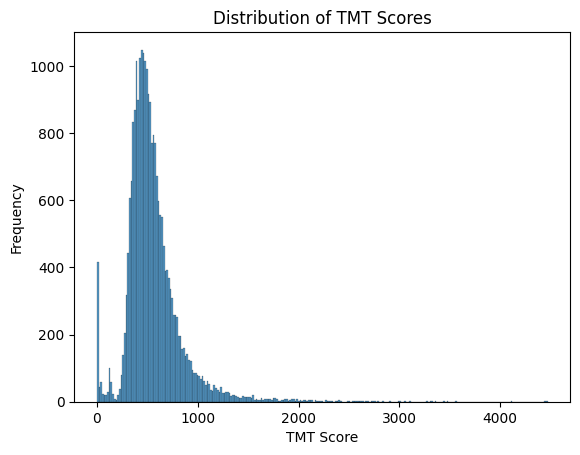

In [38]:
# Histogram of TMT Scores
sns.histplot(df['trailmaking_score'])
plt.title('Distribution of TMT Scores')
plt.xlabel('TMT Score')
plt.ylabel('Frequency')
plt.show()

In [39]:
print(len(df))
print(df.shape)

24492
(24492, 2628)


### TMT vs. MIND (avg)

In [40]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_avg_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['trailmaking_score']

print(X.shape)
print(y.shape)

(24492, 71)
(24492,)


In [41]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [42]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

Fold 01 • n_comp=04 • MAE=176.425 • RMSE=293.983 • R²=0.082
Fold 02 • n_comp=04 • MAE=172.440 • RMSE=276.644 • R²=0.073
Fold 03 • n_comp=04 • MAE=177.297 • RMSE=279.430 • R²=0.063
Fold 04 • n_comp=04 • MAE=172.116 • RMSE=269.513 • R²=0.079
Fold 05 • n_comp=04 • MAE=171.227 • RMSE=265.072 • R²=0.044
Fold 06 • n_comp=04 • MAE=173.696 • RMSE=262.275 • R²=0.069
Fold 07 • n_comp=04 • MAE=176.838 • RMSE=262.683 • R²=0.056
Fold 08 • n_comp=04 • MAE=170.765 • RMSE=261.890 • R²=0.082
Fold 09 • n_comp=04 • MAE=172.606 • RMSE=276.270 • R²=0.066
Fold 10 • n_comp=04 • MAE=168.278 • RMSE=260.266 • R²=0.054

=== 10-fold CV summary ===
n_components (mean ± std): 4.0 ± 0.0
MAE :  173.169 ± 2.772
RMSE:  270.803 ± 10.195
R²  :  0.067 ± 0.012


### TMT vs. MIND

In [43]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['trailmaking_score']

print(X.shape)
print(y.shape)

(24492, 2281)
(24492,)


In [44]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [45]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

Fold 01 • n_comp=06 • MAE=178.817 • RMSE=296.572 • R²=0.065
Fold 02 • n_comp=07 • MAE=176.302 • RMSE=280.124 • R²=0.049
Fold 03 • n_comp=07 • MAE=181.287 • RMSE=285.389 • R²=0.023
Fold 04 • n_comp=07 • MAE=175.723 • RMSE=273.635 • R²=0.051
Fold 05 • n_comp=06 • MAE=173.849 • RMSE=267.583 • R²=0.026
Fold 06 • n_comp=06 • MAE=176.252 • RMSE=263.684 • R²=0.059
Fold 07 • n_comp=06 • MAE=178.031 • RMSE=264.085 • R²=0.046
Fold 08 • n_comp=07 • MAE=175.083 • RMSE=265.310 • R²=0.058
Fold 09 • n_comp=05 • MAE=177.449 • RMSE=279.785 • R²=0.042
Fold 10 • n_comp=06 • MAE=171.326 • RMSE=263.140 • R²=0.033

=== 10-fold CV summary ===
n_components (mean ± std): 6.3 ± 0.6
MAE :  176.412 ± 2.607
RMSE:  273.931 ± 10.722
R²  :  0.045 ± 0.013


### TMT vs. CT

In [46]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/CT_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['trailmaking_score']

print(X.shape)
print(y.shape)

(24492, 65)
(24492,)


In [47]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [48]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

Fold 01 • n_comp=05 • MAE=176.795 • RMSE=294.811 • R²=0.076
Fold 02 • n_comp=05 • MAE=172.517 • RMSE=276.251 • R²=0.076
Fold 03 • n_comp=05 • MAE=177.328 • RMSE=279.850 • R²=0.060
Fold 04 • n_comp=05 • MAE=171.812 • RMSE=269.260 • R²=0.081
Fold 05 • n_comp=05 • MAE=171.478 • RMSE=265.403 • R²=0.042
Fold 06 • n_comp=05 • MAE=173.821 • RMSE=262.212 • R²=0.069
Fold 07 • n_comp=05 • MAE=176.760 • RMSE=262.482 • R²=0.057
Fold 08 • n_comp=05 • MAE=172.398 • RMSE=262.920 • R²=0.075
Fold 09 • n_comp=05 • MAE=173.251 • RMSE=276.179 • R²=0.067
Fold 10 • n_comp=05 • MAE=168.856 • RMSE=260.247 • R²=0.054

=== 10-fold CV summary ===
n_components (mean ± std): 5.0 ± 0.0
MAE :  173.502 ± 2.588
RMSE:  270.961 ± 10.319
R²  :  0.066 ± 0.012


### TMT vs. FC

In [49]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/FC_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0', '25741-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['trailmaking_score']

print(X.shape)
print(y.shape)

(24492, 214)
(24492,)


In [50]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [51]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

Fold 01 • n_comp=09 • MAE=175.815 • RMSE=292.650 • R²=0.090
Fold 02 • n_comp=08 • MAE=172.804 • RMSE=277.529 • R²=0.067
Fold 03 • n_comp=09 • MAE=175.728 • RMSE=277.324 • R²=0.077
Fold 04 • n_comp=08 • MAE=172.391 • RMSE=269.491 • R²=0.080
Fold 05 • n_comp=08 • MAE=169.631 • RMSE=263.416 • R²=0.056
Fold 06 • n_comp=07 • MAE=172.061 • RMSE=260.911 • R²=0.079
Fold 07 • n_comp=08 • MAE=173.836 • RMSE=261.197 • R²=0.066
Fold 08 • n_comp=08 • MAE=170.318 • RMSE=261.209 • R²=0.087
Fold 09 • n_comp=09 • MAE=169.796 • RMSE=271.336 • R²=0.099
Fold 10 • n_comp=08 • MAE=167.751 • RMSE=258.536 • R²=0.067

=== 10-fold CV summary ===
n_components (mean ± std): 8.2 ± 0.6
MAE :  172.013 ± 2.529
RMSE:  269.360 ± 10.166
R²  :  0.077 ± 0.012


# All Cognitive Data

In [12]:
# Load the dataset
df = pd.read_csv('/Users/baileyng/MIND_data/ukb_master_allcols_no_outliers.csv', index_col=0)

In [13]:
print(len(df))
print(df.shape)

24143
(24143, 2628)


### All Data vs. MIND (avg)

In [61]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_avg_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0', '25741-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df[['20016-2.0', '20197-2.0', '23324-2.0', 'trailmaking_score']]

print(X.shape)
print(y.shape)

(24143, 72)
(24143, 4)


In [62]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [63]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

Fold 01 • n_comp=06 • MAE=45.892 • RMSE=143.108 • R²=0.087
Fold 02 • n_comp=06 • MAE=43.098 • RMSE=125.957 • R²=0.085
Fold 03 • n_comp=06 • MAE=44.172 • RMSE=136.246 • R²=0.093
Fold 04 • n_comp=06 • MAE=44.269 • RMSE=128.711 • R²=0.083
Fold 05 • n_comp=06 • MAE=42.912 • RMSE=125.288 • R²=0.099
Fold 06 • n_comp=06 • MAE=44.759 • RMSE=140.403 • R²=0.084
Fold 07 • n_comp=06 • MAE=45.050 • RMSE=133.851 • R²=0.095
Fold 08 • n_comp=06 • MAE=42.585 • RMSE=122.742 • R²=0.095
Fold 09 • n_comp=06 • MAE=43.522 • RMSE=128.504 • R²=0.102
Fold 10 • n_comp=06 • MAE=45.062 • RMSE=133.976 • R²=0.097

=== 10-fold CV summary ===
n_components (mean ± std): 6.0 ± 0.0
MAE :  44.132 ± 1.027
RMSE:  131.878 ± 6.399
R²  :  0.092 ± 0.007


### All Data vs. MIND

In [64]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0', '25741-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df[['20016-2.0', '20197-2.0', '23324-2.0', 'trailmaking_score']]

print(X.shape)
print(y.shape)

(24143, 2282)
(24143, 4)


In [65]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [66]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

Fold 01 • n_comp=10 • MAE=45.916 • RMSE=143.128 • R²=0.079
Fold 02 • n_comp=10 • MAE=43.441 • RMSE=126.412 • R²=0.072
Fold 03 • n_comp=10 • MAE=44.558 • RMSE=136.892 • R²=0.084
Fold 04 • n_comp=10 • MAE=44.790 • RMSE=129.639 • R²=0.069
Fold 05 • n_comp=10 • MAE=43.510 • RMSE=126.572 • R²=0.080
Fold 06 • n_comp=10 • MAE=45.045 • RMSE=140.842 • R²=0.076
Fold 07 • n_comp=10 • MAE=45.531 • RMSE=135.287 • R²=0.073
Fold 08 • n_comp=10 • MAE=42.875 • RMSE=123.305 • R²=0.083
Fold 09 • n_comp=09 • MAE=44.375 • RMSE=129.982 • R²=0.078
Fold 10 • n_comp=10 • MAE=45.210 • RMSE=135.031 • R²=0.086

=== 10-fold CV summary ===
n_components (mean ± std): 9.9 ± 0.3
MAE :  44.525 ± 0.933
RMSE:  132.709 ± 6.220
R²  :  0.078 ± 0.005


### All Data vs. CT

In [67]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/CT_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0', '25741-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df[['20016-2.0', '20197-2.0', '23324-2.0', 'trailmaking_score']]

print(X.shape)
print(y.shape)

(24143, 66)
(24143, 4)


In [68]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [69]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

Fold 01 • n_comp=08 • MAE=46.059 • RMSE=143.054 • R²=0.083
Fold 02 • n_comp=08 • MAE=42.990 • RMSE=125.628 • R²=0.084
Fold 03 • n_comp=08 • MAE=44.391 • RMSE=136.461 • R²=0.088
Fold 04 • n_comp=08 • MAE=44.538 • RMSE=129.339 • R²=0.078
Fold 05 • n_comp=08 • MAE=43.019 • RMSE=125.670 • R²=0.095
Fold 06 • n_comp=08 • MAE=44.875 • RMSE=140.566 • R²=0.080
Fold 07 • n_comp=08 • MAE=45.162 • RMSE=133.795 • R²=0.096
Fold 08 • n_comp=08 • MAE=42.822 • RMSE=123.141 • R²=0.088
Fold 09 • n_comp=08 • MAE=43.660 • RMSE=128.577 • R²=0.098
Fold 10 • n_comp=08 • MAE=45.093 • RMSE=134.540 • R²=0.093

=== 10-fold CV summary ===
n_components (mean ± std): 8.0 ± 0.0
MAE :  44.261 ± 1.039
RMSE:  132.077 ± 6.348
R²  :  0.088 ± 0.007


### All Data vs. FC

In [70]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/FC_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0', '25741-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df[['20016-2.0', '20197-2.0', '23324-2.0', 'trailmaking_score']]

print(X.shape)
print(y.shape)

(24143, 214)
(24143, 4)


In [71]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [72]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

Fold 01 • n_comp=07 • MAE=45.260 • RMSE=141.670 • R²=0.099
Fold 02 • n_comp=07 • MAE=42.725 • RMSE=125.016 • R²=0.099
Fold 03 • n_comp=07 • MAE=43.924 • RMSE=135.677 • R²=0.105
Fold 04 • n_comp=07 • MAE=43.800 • RMSE=127.643 • R²=0.099
Fold 05 • n_comp=07 • MAE=42.919 • RMSE=125.311 • R²=0.110
Fold 06 • n_comp=07 • MAE=44.613 • RMSE=140.063 • R²=0.097
Fold 07 • n_comp=07 • MAE=44.448 • RMSE=132.422 • R²=0.113
Fold 08 • n_comp=07 • MAE=42.488 • RMSE=122.249 • R²=0.103
Fold 09 • n_comp=08 • MAE=43.156 • RMSE=128.005 • R²=0.115
Fold 10 • n_comp=10 • MAE=44.676 • RMSE=133.820 • R²=0.120

=== 10-fold CV summary ===
n_components (mean ± std): 7.4 ± 0.9
MAE :  43.801 ± 0.898
RMSE:  131.187 ± 6.265
R²  :  0.106 ± 0.008
